In [1]:
!pip install stable-baselines3[extra] -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 94.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 56.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 39.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 86.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 184.5/184.5 kB 10.4 MB/s eta 0:00:00


Using cpu device
-----------------------------
| time/              |      |
|    fps             | 863  |
|    iterations      | 1    |
|    time_elapsed    | 2    |
|    total_timesteps | 2048 |
-----------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 664          |
|    iterations           | 2            |
|    time_elapsed         | 6            |
|    total_timesteps      | 4096         |
| train/                  |              |
|    approx_kl            | 0.0140489815 |
|    clip_fraction        | 0.161        |
|    clip_range           | 0.2          |
|    entropy_loss         | -1.38        |
|    explained_variance   | -0.00586     |
|    learning_rate        | 0.00025      |
|    loss                 | 597          |
|    n_updates            | 10           |
|    policy_gradient_loss | -0.0255      |
|    value_loss           | 1.59e+03     |
------------------------------------------

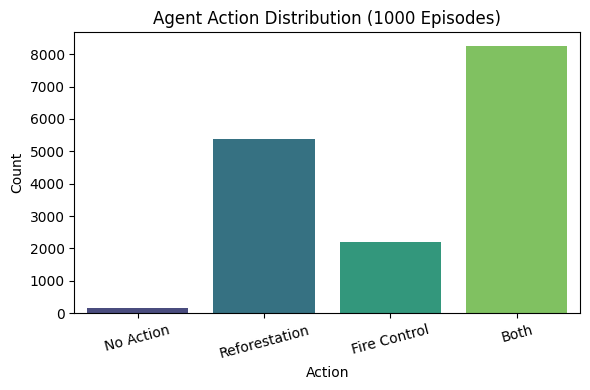

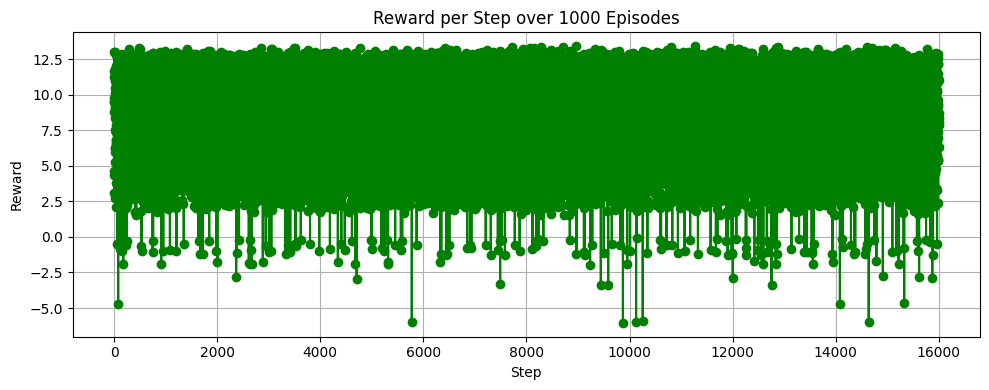

In [2]:
# ================================
# 0. Imports
# ================================
import gymnasium as gym
from gymnasium import spaces
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import os
from collections import Counter
from stable_baselines3 import PPO, DQN, A2C
from stable_baselines3.common.vec_env import DummyVecEnv
from stable_baselines3.common.monitor import Monitor

# ================================
# 1. Load and Preprocess Data
# ================================
file_paths = {
    "deforestation": "/content/def_area_2004_2019.csv",
    "el_nino": "/content/el_nino_la_nina_1999_2019.csv",
    "fires": "/content/inpe_brazilian_amazon_fires_1999_2019.csv",
}

dfs = {name: pd.read_csv(path) for name, path in file_paths.items()}

df_def = dfs["deforestation"].rename(columns={"Ano/Estados": "year"})
df_def = df_def[["year", "AMZ LEGAL"]]

df_fires = dfs["fires"].groupby("year")["firespots"].sum().reset_index()

df_elnino = dfs["el_nino"].copy()
df_elnino["phenomenon"] = df_elnino["phenomenon"].map({"El Nino": 1, "La Nina": -1}).fillna(0)
df_elnino = df_elnino.groupby("start year")["phenomenon"].mean().reset_index()
df_elnino.rename(columns={"start year": "year"}, inplace=True)

df_combined = df_def.merge(df_fires, on="year", how="inner").merge(df_elnino, on="year", how="left")
df_combined["phenomenon"] = df_combined["phenomenon"].fillna(0)

np.random.seed(42)
def generate_synthetic_data(row):
    if row["phenomenon"] == 1:
        return pd.Series({
            "Temperature": np.random.uniform(0.2, 1.0),
            "Rainfall": np.random.uniform(-1.0, -0.5),
            "Biodiversity": np.random.uniform(0.2, 0.5),
            "Carbon_Sequestration": np.random.uniform(0.1, 0.3),
            "Cost_Efficiency": np.random.uniform(0.3, 0.6),
        })
    elif row["phenomenon"] == -1:
        return pd.Series({
            "Temperature": np.random.uniform(-1.0, -0.5),
            "Rainfall": np.random.uniform(0.5, 1.0),
            "Biodiversity": np.random.uniform(0.6, 1.0),
            "Carbon_Sequestration": np.random.uniform(0.6, 1.0),
            "Cost_Efficiency": np.random.uniform(0.2, 0.5),
        })
    else:
        return pd.Series({
            "Temperature": np.random.uniform(-0.2, 0.2),
            "Rainfall": np.random.uniform(0.0, 0.2),
            "Biodiversity": np.random.uniform(0.3, 0.7),
            "Carbon_Sequestration": np.random.uniform(0.3, 0.6),
            "Cost_Efficiency": np.random.uniform(0.4, 0.8),
        })

df_combined[["Temperature", "Rainfall", "Biodiversity", "Carbon_Sequestration", "Cost_Efficiency"]] = df_combined.apply(generate_synthetic_data, axis=1)

cols_to_normalize = ["AMZ LEGAL", "firespots", "Temperature", "Rainfall", "Biodiversity", "Carbon_Sequestration", "Cost_Efficiency"]
normalization_params = {}
for col in cols_to_normalize:
    min_val = df_combined[col].min()
    max_val = df_combined[col].max()
    normalization_params[col] = {"min": min_val, "max": max_val}
    df_combined[col] = (df_combined[col] - min_val) / (max_val - min_val)

os.makedirs("model", exist_ok=True)
joblib.dump(normalization_params, "model/normalization_params.pkl")

# ================================
# 2. Define Custom Gym Environment
# ================================
class AmazonReforestationEnv(gym.Env):
    metadata = {"render.modes": ["human"]}

    def __init__(self, df):
        super().__init__()
        self.df = df.reset_index(drop=True)
        self.current_step = 0
        self.max_steps = len(self.df)
        self.action_space = spaces.Discrete(4)
        self.observation_space = spaces.Box(
            low=np.array([0, 0, -1, 0, 0, 0], dtype=np.float32),
            high=np.array([1, 1, 1, 1, 1, 1], dtype=np.float32),
            dtype=np.float32
        )

    def _get_state(self):
        row = self.df.iloc[self.current_step]
        return np.array([
            row["firespots"],
            row["AMZ LEGAL"],
            row["phenomenon"],
            row["Temperature"],
            row["Rainfall"],
            np.random.uniform(0, 1)
        ], dtype=np.float32)

    def reset(self, seed=None, options=None):
        self.current_step = 0
        return self._get_state(), {}

    def step(self, action):
        row = self.df.iloc[self.current_step]
        fires = row["firespots"]
        deforestation = row["AMZ LEGAL"]
        rain = row["Rainfall"]
        bio = row["Biodiversity"]
        carbon = row["Carbon_Sequestration"]
        cost = row["Cost_Efficiency"]
        budget = np.random.uniform(0, 1)

        # Multi-objective reward function
        w_bio, w_carbon, w_cost = 2, 2, 1.5
        w_fires, w_defor, w_rain, w_budget = 4, 4, 3, 2

        reforestation_reward = (
            w_defor * (1 - deforestation)
            + w_rain * rain
            + w_budget * (1 - budget)
            + w_bio * bio
            + w_carbon * carbon
            + w_cost * cost
        )

        fire_control_reward = (
            w_fires * (1 - fires)
            + w_rain * rain
            + w_budget * (1 - budget)
            + w_bio * bio * 0.5
            + w_carbon * carbon * 0.5
            + w_cost * cost * 0.8
        )

        combined_reward = (
            5 * ((1 - fires + 1 - deforestation) / 2)
            + w_rain * rain
            + w_budget * (1 - budget)
            + w_bio * bio
            + w_carbon * carbon
            + w_cost * cost
        )

        no_action_penalty = -3 * (fires + deforestation)
        noise = np.random.normal(0, 0.05)

        reward = {
            0: no_action_penalty,
            1: reforestation_reward,
            2: fire_control_reward,
            3: combined_reward
        }.get(int(action), -1) + noise

        self.current_step += 1
        done = self.current_step >= self.max_steps
        next_state = self._get_state() if not done else np.zeros(self.observation_space.shape, dtype=np.float32)
        return next_state, reward, done, False, {}

    def render(self, mode="human"):
        print(f"Step {self.current_step} — State: {self._get_state()}")

# ================================
# 3. Train PPO Agent
# ================================
env = DummyVecEnv([lambda: AmazonReforestationEnv(df_combined)])
model = PPO("MlpPolicy", env, verbose=1, ent_coef=0.05, n_steps=2048, batch_size=64, gamma=0.99, learning_rate=2.5e-4)
model.learn(total_timesteps=100_000)
model.save("model/ppo_amazon_agent")
print("✅ PPO Model trained and saved.")

# ================================
# 4. Test & Visualize Results
# ================================
test_env = AmazonReforestationEnv(df_combined)
actions_taken = []
rewards_list = []

for _ in range(1000):
    obs, _ = test_env.reset()
    done = False
    while not done:
        action, _ = model.predict(obs, deterministic=False)
        obs, reward, done, _, _ = test_env.step(action)
        actions_taken.append(int(action))
        rewards_list.append(reward)

action_labels = ['No Action', 'Reforestation', 'Fire Control', 'Both']
counts = Counter(actions_taken)
print("\nAction Distribution over 1000 Episodes:")
for i in range(4):
    print(f"{action_labels[i]}: {counts[i]} times")

action_data = pd.DataFrame({
    "Action": action_labels,
    "Count": [counts[i] for i in range(4)]
})
plt.figure(figsize=(6, 4))
sns.barplot(data=action_data, x="Action", y="Count", hue="Action", palette="viridis", legend=False)
plt.title("Agent Action Distribution (1000 Episodes)")
plt.ylabel("Count")
plt.xticks(rotation=15)
plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 4))
plt.plot(rewards_list, marker='o', linestyle='-', color='green')
plt.title("Reward per Step over 1000 Episodes")
plt.xlabel("Step")
plt.ylabel("Reward")
plt.grid(True)
plt.tight_layout()
plt.show()


In [3]:
# ================================
# 5. Train DQN Agent
# ================================
dqn_env = DummyVecEnv([lambda: AmazonReforestationEnv(df_combined)])
dqn_model = DQN("MlpPolicy", dqn_env, verbose=1, learning_rate=1e-3, buffer_size=10000, exploration_fraction=0.1)
dqn_model.learn(total_timesteps=100_000)
dqn_model.save("model/dqn_amazon_agent")
print("✅ DQN Model trained and saved.")

# ================================
# 6. Train A2C Agent
# ================================
a2c_env = DummyVecEnv([lambda: AmazonReforestationEnv(df_combined)])
a2c_model = A2C("MlpPolicy", a2c_env, verbose=1, learning_rate=7e-4)
a2c_model.learn(total_timesteps=100_000)
a2c_model.save("model/a2c_amazon_agent")
print("✅ A2C Model trained and saved.")


Streaming output truncated to the last 5000 lines.
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 5576     |
|    fps              | 597      |
|    time_elapsed     | 149      |
|    total_timesteps  | 89216    |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 1.37     |
|    n_updates        | 22278    |
----------------------------------
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 5580     |
|    fps              | 597      |
|    time_elapsed     | 149      |
|    total_timesteps  | 89280    |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 1.36     |
|    n_updates        | 22294    |
----------------------------------
----------------------------------
| ro

In [ ]:
def evaluate_agent(model, agent_name, env_class, df_data, episodes=1000):
    env = env_class(df_data)
    actions_taken = []
    rewards_list = []

    for _ in range(episodes):
        obs, _ = env.reset()
        done = False
        while not done:
            action, _ = model.predict(obs, deterministic=False)
            obs, reward, done, _, _ = env.step(action)
            actions_taken.append(int(action))
            rewards_list.append(reward)

    # Action distribution plot
    action_labels = ['No Action', 'Reforestation', 'Fire Control', 'Both']
    counts = Counter(actions_taken)

    print(f"\n📊 {agent_name} — Action Distribution over {episodes} Episodes:")
    for i in range(4):
        print(f"{action_labels[i]}: {counts[i]} times")

    action_data = pd.DataFrame({
        "Action": action_labels,
        "Count": [counts[i] for i in range(4)]
    })

    plt.figure(figsize=(6, 4))
    sns.barplot(data=action_data, x="Action", y="Count", hue="Action", palette="magma", legend=False)
    plt.title(f"{agent_name}: Action Distribution")
    plt.ylabel("Count")
    plt.xticks(rotation=15)
    plt.tight_layout()
    plt.show()

    # Reward plot
    plt.figure(figsize=(10, 4))
    plt.plot(rewards_list, marker='o', linestyle='-', color='purple')
    plt.title(f"{agent_name}: Reward per Step")
    plt.xlabel("Step")
    plt.ylabel("Reward")
    plt.grid(True)
    plt.tight_layout()
    plt.show()



📊 DQN Agent — Action Distribution over 1000 Episodes:
No Action: 194 times
Reforestation: 1509 times
Fire Control: 192 times
Both: 14105 times


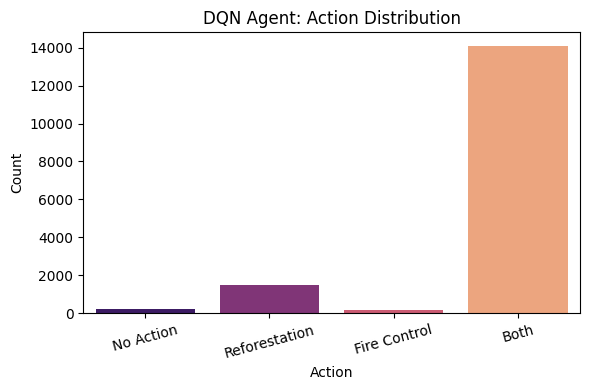

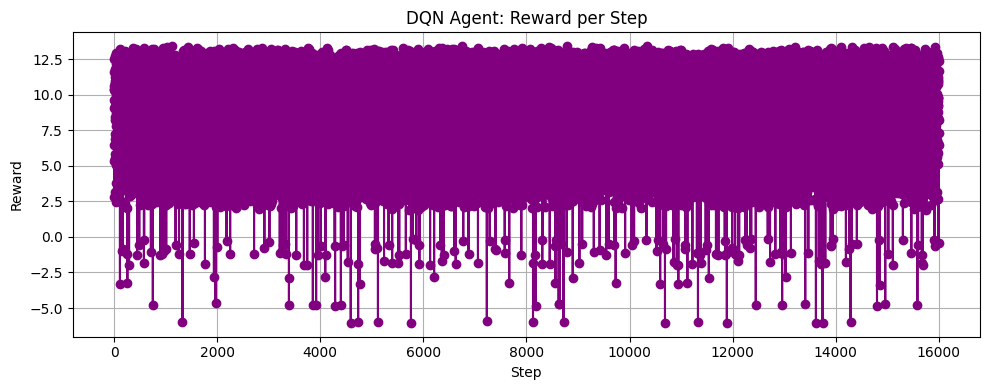


📊 A2C Agent — Action Distribution over 1000 Episodes:
No Action: 0 times
Reforestation: 0 times
Fire Control: 0 times
Both: 16000 times


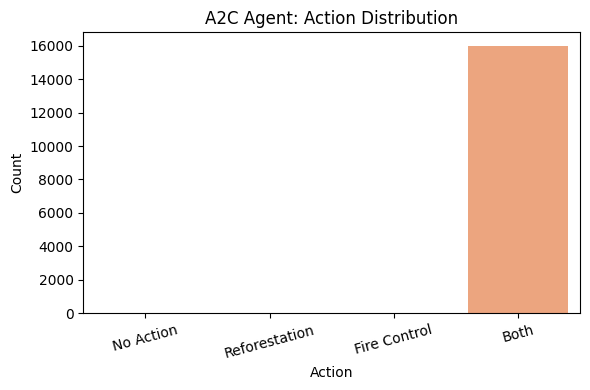

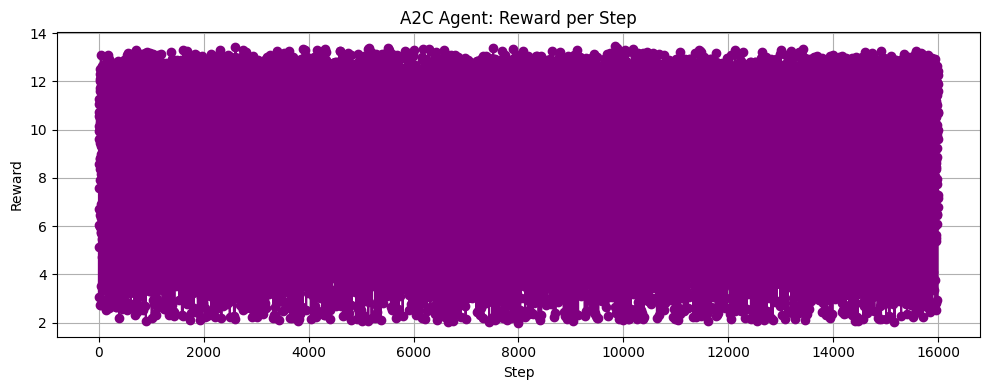

In [ ]:
# Evaluate DQN agent
evaluate_agent(dqn_model, "DQN Agent", AmazonReforestationEnv, df_combined)

# Evaluate A2C agent
evaluate_agent(a2c_model, "A2C Agent", AmazonReforestationEnv, df_combined)


In [ ]:
def evaluate_agent(model, env_class, name, episodes=1000):
    env = env_class(df_combined)
    rewards = []
    actions = []
    for _ in range(episodes):
        obs, _ = env.reset()
        done = False
        while not done:
            action, _ = model.predict(obs, deterministic=True)
            obs, reward, done, _, _ = env.step(action)
            rewards.append(reward)
            actions.append(int(action))  # 🔥 fix: ensure action is int
    avg_reward = np.mean(rewards)
    std_reward = np.std(rewards)
    print(f"\n{name} Evaluation:")
    print(f"Avg Reward: {avg_reward:.4f}, Std Dev: {std_reward:.4f}")
    return actions, rewards


In [ ]:
ppo_actions, ppo_rewards = evaluate_agent(model, AmazonReforestationEnv, "PPO")
dqn_actions, dqn_rewards = evaluate_agent(dqn_model, AmazonReforestationEnv, "DQN")
a2c_actions, a2c_rewards = evaluate_agent(a2c_model, AmazonReforestationEnv, "A2C")



PPO Evaluation:
Avg Reward: 9.0205, Std Dev: 2.6686

DQN Evaluation:
Avg Reward: 9.0618, Std Dev: 2.6715

A2C Evaluation:
Avg Reward: 9.0142, Std Dev: 2.6635


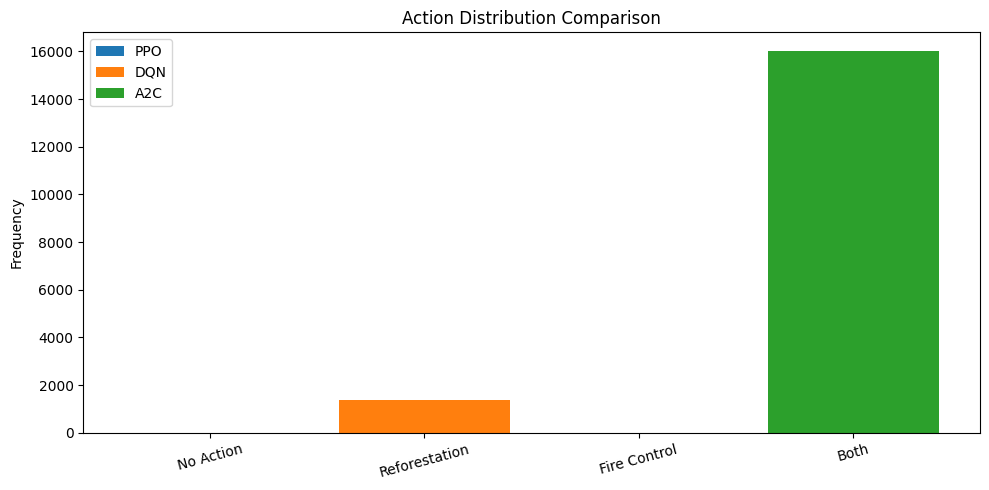

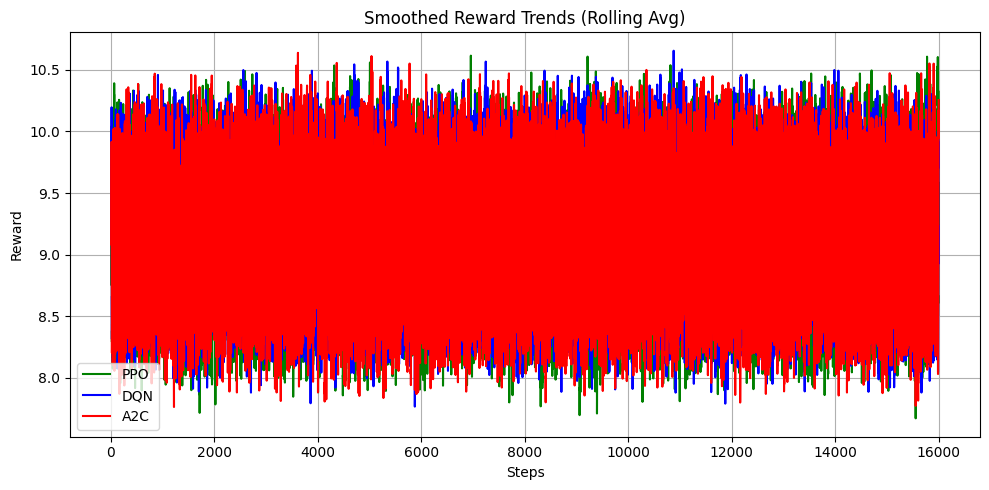

In [ ]:
# Action Distribution
def plot_action_dist(actions, label):
    counts = Counter(actions)
    labels = ['No Action', 'Reforestation', 'Fire Control', 'Both']
    plt.bar(labels, [counts[i] for i in range(4)], label=label)

plt.figure(figsize=(10, 5))
plot_action_dist(ppo_actions, "PPO")
plot_action_dist(dqn_actions, "DQN")
plot_action_dist(a2c_actions, "A2C")
plt.title("Action Distribution Comparison")
plt.ylabel("Frequency")
plt.legend()
plt.xticks(rotation=15)
plt.tight_layout()
plt.show()

# Reward Trend Comparison
plt.figure(figsize=(10, 5))
plt.plot(pd.Series(ppo_rewards).rolling(10).mean(), label="PPO", color='green')
plt.plot(pd.Series(dqn_rewards).rolling(10).mean(), label="DQN", color='blue')
plt.plot(pd.Series(a2c_rewards).rolling(10).mean(), label="A2C", color='red')
plt.title("Smoothed Reward Trends (Rolling Avg)")
plt.xlabel("Steps")
plt.ylabel("Reward")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
